In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys
import random
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import tensorflow as tf


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv
/kaggle/input/tgs-salt-identification-challenge/depths.csv
/kaggle/input/tgs-salt-identification-challenge/test.zip
/kaggle/input/tgs-salt-identification-challenge/flamingo.zip
/kaggle/input/tgs-salt-identification-challenge/train.zip
/kaggle/input/tgs-salt-identification-challenge/competition_data.zip
/kaggle/input/tgs-salt-identification-challenge/train.csv


In [2]:
import zipfile
with zipfile.ZipFile("/kaggle/input/tgs-salt-identification-challenge/train.zip") as z:
    z.extractall("./train/")

In [3]:
import zipfile
with zipfile.ZipFile("/kaggle/input/tgs-salt-identification-challenge/test.zip") as z:
    z.extractall("./test/")

In [4]:
TRAIN_IMAGE_DIR = '/kaggle/working/train/images/'
TRAIN_MASK_DIR = '/kaggle/working/train/masks/'
TEST_IMAGE_DIR = '/kaggle/working/test/images/'

im_width = 128
im_height = 128
im_chan = 1

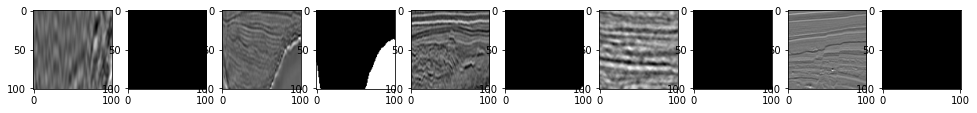

In [5]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(TRAIN_IMAGE_DIR + img_name + '.png')
    img_mask = load_img(TRAIN_MASK_DIR + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [6]:
train_ids=os.listdir(TRAIN_IMAGE_DIR)

In [7]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
#sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = load_img(TRAIN_IMAGE_DIR + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(TRAIN_MASK_DIR + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Done!


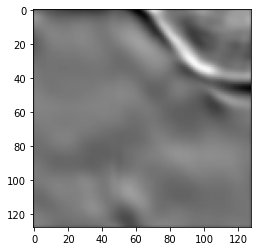

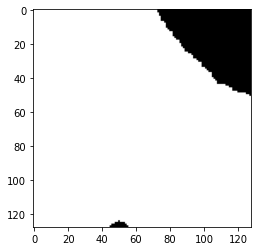

In [8]:
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [21]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 8)  80          lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 8)  584         conv2d_20[0][0]                  
____________________________________________________________________________________________

In [22]:
callbacks =[EarlyStopping(patience=10, verbose=1),ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True),
ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
           ]
results = model.fit(X_train, Y_train, validation_split=0.2, shuffle=True,batch_size=16, epochs=50, 
                    callbacks=callbacks)

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.5538 - mean_io_u_1: 0.3753 - val_loss: 0.4462 - val_mean_io_u_1: 0.3739

Epoch 00001: val_loss improved from inf to 0.44621, saving model to model-tgs-salt-1.h5
Epoch 2/50
3200/3200 [==============================] - 4s 1ms/step - loss: 0.5141 - mean_io_u_1: 0.3736 - val_loss: 0.4844 - val_mean_io_u_1: 0.3745

Epoch 00002: val_loss did not improve from 0.44621
Epoch 3/50
3200/3200 [==============================] - 5s 1ms/step - loss: 0.4093 - mean_io_u_1: 0.3742 - val_loss: 0.4229 - val_mean_io_u_1: 0.3744

Epoch 00003: val_loss improved from 0.44621 to 0.42294, saving model to model-tgs-salt-1.h5
Epoch 4/50
3200/3200 [==============================] - 4s 1ms/step - loss: 0.3553 - mean_io_u_1: 0.3746 - val_loss: 0.4169 - val_mean_io_u_1: 0.3744

Epoch 00004: val_loss improved from 0.42294 to 0.41691, saving model to model-tgs-salt-1.h5
Epoch 5/50
3200/3200 [====

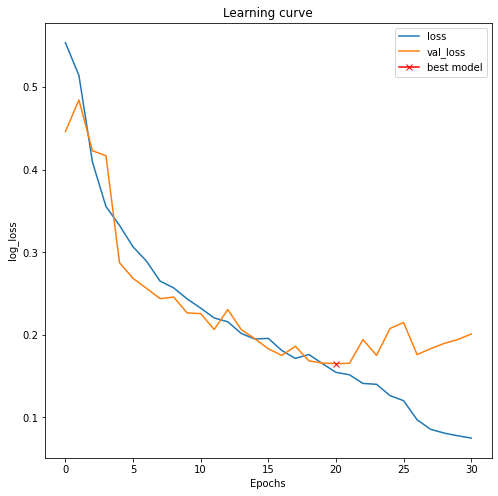

In [23]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [24]:
test_ids=os.listdir(TEST_IMAGE_DIR)

In [ ]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    img = load_img(TEST_IMAGE_DIR + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# Predict on train, val and test
#model = load_model('model-tgs-salt-1.h5')

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [ ]:
ix = random.randint(0, len(preds_test_t))
plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()